# More complex trough models
The previous notebooks used the most basic trough model, with a constant lag $l(t) = l_0$ and an accumulation that is a linear function of the insolation $A(t) = aI(t)$. The next most complicated models can either make the lag linear in time or making the accumulation quadratic in insolation: $l(t) = l_0 + l_1t$ and $A(t) = aI + bI^2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mars_troughs as mt
import scipy.optimize as op
%matplotlib inline

In [2]:
print("Creating a trough object.")
test_acc_params = [1e-6]
acc_model_number = 0
test_lag_params = [1, 1e-6]
lag_model_number = 1
errorbar = 100.
tr = mt.Trough(test_acc_params, test_lag_params,
                acc_model_number, lag_model_number,
                errorbar)

Creating a trough object.


In [3]:
#Define the log likelihood
def ln_likelihood(params):
    variance = params[0]
    if variance < 0:
        return -1e99
    acc_params = np.array([params[1]])
    lag_params = np.array([params[2:4]]).flatten()
    tr.set_model(acc_params, lag_params, np.sqrt(variance))
    if any(tr.lags_t < 0) or any(tr.lags_t > 20):
        #print("here")
        #print(tr.lags_t)
        return -1e99
    tr.compute_splines()
    return tr.lnlikelihood()

#And the negative of the log likelihood
def neg_ln_likelihood(params):
    return -ln_likelihood(params)

In [4]:
guess = [errorbar**2, test_acc_params[0], 
         test_lag_params[0], test_lag_params[1]]
result = op.minimize(neg_ln_likelihood, x0=guess, method='Nelder-Mead')
print(result)

 final_simplex: (array([[4.06262561e+03, 1.19534540e-06, 1.30346155e+00, 1.06485154e-06],
       [4.06262553e+03, 1.19534540e-06, 1.30346158e+00, 1.06485153e-06],
       [4.06262556e+03, 1.19534540e-06, 1.30346148e+00, 1.06485158e-06],
       [4.06262561e+03, 1.19534540e-06, 1.30346154e+00, 1.06485154e-06],
       [4.06262560e+03, 1.19534540e-06, 1.30346154e+00, 1.06485154e-06]]), array([74.47667772, 74.47667772, 74.47667772, 74.47667772, 74.47667772]))
           fun: 74.47667772355756
       message: 'Optimization terminated successfully.'
          nfev: 458
           nit: 247
        status: 0
       success: True
             x: array([4.06262561e+03, 1.19534540e-06, 1.30346155e+00, 1.06485154e-06])


In [5]:
#Set the model to the best model
best = result['x']
variance = best[0]
acc_params = np.array([best[1]])
lag_params = np.array([best[2:4]]).flatten()
tr.set_model(acc_params, lag_params, np.sqrt(variance))

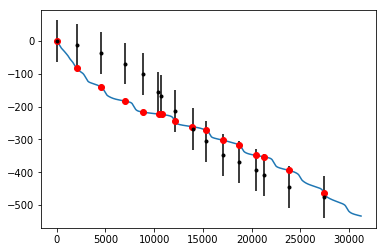

In [6]:
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
plt.errorbar(tr.xdata, tr.ydata, yerr=tr.errorbar, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')

In [7]:
import emcee
import corner

In [8]:
ndim = len(result.x)
nwalkers = ndim*4
nburn = 200
nsteps = 2000
p0 = [result.x + 1e-3*result.x*np.random.randn(ndim) for i in range(nwalkers)]

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood)
_ = sampler.run_mcmc(p0, nburn)

In [10]:
p0 = sampler.chain[:,-1]
sampler.reset()
_ = sampler.run_mcmc(p0, nsteps)
chain = sampler.flatchain

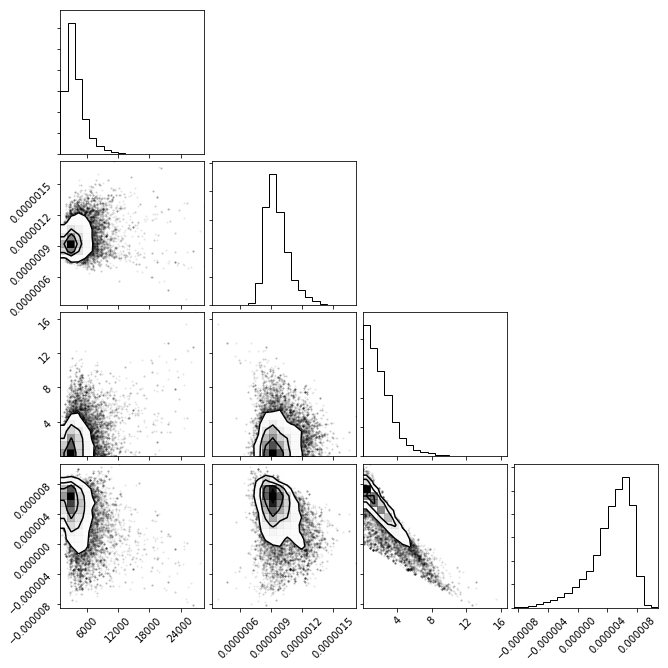

In [11]:
fig = corner.corner(chain)

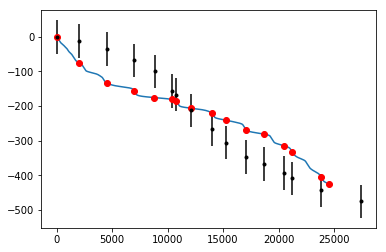

In [13]:
#Set the model to the best model
best = chain[np.argmax(sampler.flatlnprobability)]
variance = best[0]
acc_params = np.array([best[1]])
lag_params = np.array([best[2:4]]).flatten()
tr.set_model(acc_params, lag_params, np.sqrt(variance))
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
plt.errorbar(tr.xdata, tr.ydata, yerr=tr.errorbar, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')